This notebook takes borehole data and SNMR data from the East Kimberley and creates a map of water tables.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon, shape
import fiona
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from datetime import datetime
import matplotlib.pyplot as plt
import os, sys
import sqlalchemy as db
from sqlalchemy import create_engine, event
import yaml
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
import warnings
import math
warnings.filterwarnings("ignore",category =RuntimeWarning)
# Kriging packages
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.rk import Krige
from pykrige.compat import GridSearchCV
# Regression kriging functions
from sklearn.linear_model import Ridge
from pykrige.rk import RegressionKriging
from pykrige.compat import GridSearchCV
from pykrige.compat import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
def find_optimal_index(pred_prob):
    # Find the index of the optimal place to put the water table
    
    # Iterate through the NMR layers and find the average of the 
    # probabilities of being in class 1 (saturated) for all layers
    # below the layer
    
    objective = np.nan*np.ones(shape = pred_prob[:,0].shape, dtype = np.float)
    
    # For the first layer we use the p(saturated of layer 1)
    objective[0] = pred_prob[0,1]

    for i in range(1,pred_prob.shape[0]):
        # For subsequent layers we sum the probability of all layers below being in class
        # one with the probability of all layers above not being in class one
        objective[i] = (np.mean(pred_prob[i:,1]) + 1 - np.mean(pred_prob[:i,1]))/2
    
    return np.argmax(objective)
        

In [3]:
# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

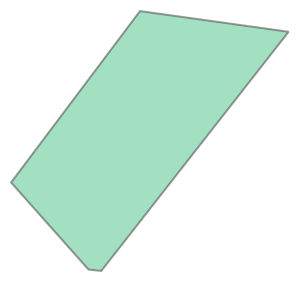

In [4]:
# Display
OrdKeep = polygons[names.index('Wider_Keep')]

OrdKeep

In [5]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [6]:
# Custom query so we can join on the standing water level table

query = """

select
   b.borehole_id,
   b.Borehole_name,
   b.Easting,
   b.Northing,
   b.Ground_elevation_mAHD,
   swl.Date,
   swl.Depth

from

   borehole b
   left join standing_water_level  swl on b.borehole_id = swl.borehole_id
   
where

   within(b.geom,GeomFromText('{}'))
   
and

   b.SWL_available = 1;""".format(OrdKeep)


df_swl = pd.read_sql(query, connection)

# Rename the depth column
df_swl = df_swl.rename(columns = {"Depth": "SWL_depth"})

In [7]:
# Extract the borehole ids into an array

enos = df_swl['borehole_id'].unique()


In [8]:

# Find the days since the measurement was taken
date_format = "%Y-%m-%d"
today = datetime.now()
days_ago= [(today - datetime.strptime(x, date_format)).days for x in df_swl['Date']]
df_swl['days_since_swl'] = days_ago


In [9]:
# For duplicate entries we will drop the measurements that were taken longer ago

# Minimum indices will be added to a list
min_ind = []

# Iterate through the enos
for item in enos:
    # Get the subset using the eno as a mask
    df_subset = borehole_utils.extract_by_primary_key(df_swl,[item])
    # Find the minumum index using the days since the measurement was takes
    min_ind.append(df_subset['days_since_swl'].argmin())

# Filter usign the minimum index
df_swl = df_swl.loc[min_ind,:] 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# Drop the pesky artesian well, this is conined and thus not usefule
# for defining a water table surface

df_swl = df_swl[df_swl["SWL_depth"] > 0.]

In [11]:
# Create a water level elevation column

df_swl['wl_mAHD'] = df_swl['Ground_elevation_mAHD'] - df_swl['SWL_depth']

utm_zone = 52
48 points in UTM bounding box: [481885.0, 8274026.4, 542732.935, 8333350.0]


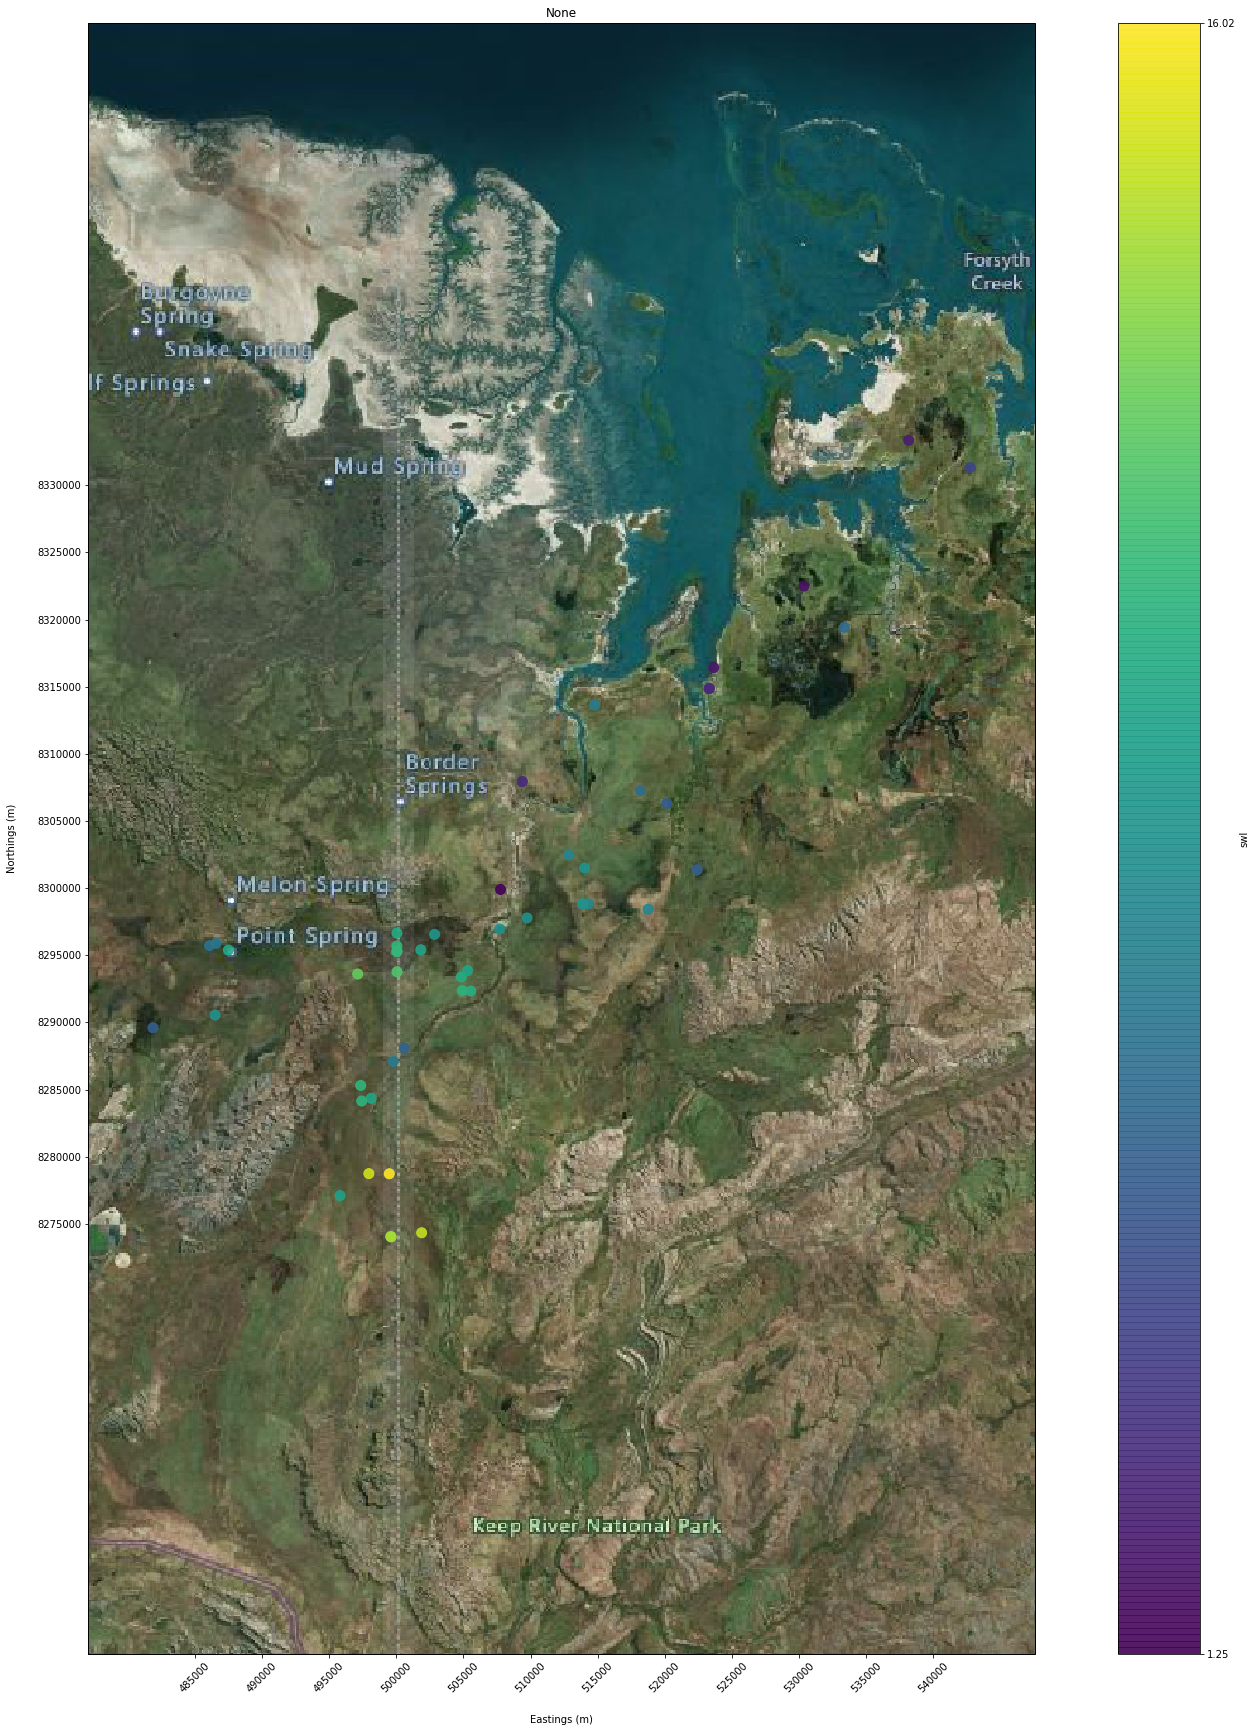

In [12]:
# Plot the bores on a basemap to get an idea of what the swl data looks like

bore_coords = df_swl[['Easting', 'Northing']].values


swl = df_swl["SWL_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(bore_coords, "EPSG:28352", swl, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


In [13]:
# WE trial anumber of models to find which kriging model will fit the best
# the data

# From https://pykrige.readthedocs.io/en/latest/examples/krige_cv.html#sphx-glr-examples-krige-cv-py

# 2D Kring param opt

param_dict = {"method": ["ordinary", "universal"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
               "nlags": [4, 6, 8],
               "weight": [True, False]
              }
# We will use cross validation
estimator = GridSearchCV(Krige(), param_dict, verbose=True,
                        scoring = 'explained_variance')

# data
X = bore_coords
y = swl

# run the gridsearch
estimator.fit(X=X, y=y)



# The results
print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points wil

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    6.0s finished
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [14]:
#Print the best results
if hasattr(estimator, 'best_score_'):
    print('best_score variance explained = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

best_score variance explained = 0.605
best_params =  {'method': 'universal', 'nlags': 4, 'variogram_model': 'power', 'weight': True}


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.00045293868745504206
Nugget: 2.787424761305156 



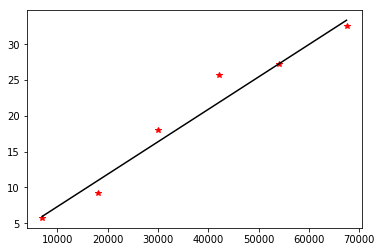

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'power' Variogram Model
Scale: 1.392206127217699e-05
Exponent: 1.3335140079275316
Nugget: 3.6614009116091344 



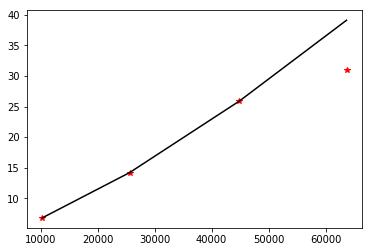

Calculating statistics on variogram model fit...
Q1 = 0.07704477828334703
Q2 = 0.928365103672162
cR = 5.854883535502295 

Initializing drift terms...
Implementing regional linear drift.
Executing Ordinary Kriging...

Executing Universal Kriging...



In [15]:

X = bore_coords[:,0]
Y = bore_coords[:,1]

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 50)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 50)[::-1]

# Create the ordinary kriging object

OK = OrdinaryKriging(X, Y, swl, variogram_model='linear',
                     verbose=True, enable_plotting=True)

UK = UniversalKriging(X, Y, swl, variogram_model='power',
                      drift_terms=['regional_linear'],
                      nlags = 4, weight = True,
                     verbose=True, enable_plotting=True)

# Creates the kriged grid and the variance grid
zo, sso = OK.execute('grid', gridx, gridy)
zu, ssu = UK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
#kt.write_asc_grid(gridx, gridy, z, filename=r"C:\temp\output.asc")



In [16]:
# Create a mask for points with a variance of 
# greater than 20

masko = sso.data > 20.
masku = ssu.data > 20.

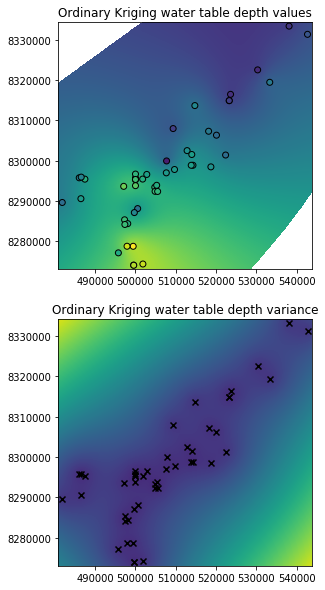

In [17]:
# plot the results for the Ordinary Kriging
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (40,10))

# Mask the array
swl_results = np.copy(zo.data)

swl_results[masko] = np.nan

ax1.imshow(swl_results, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0., vmax = 16.)

ax2.imshow(sso.data, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0, vmax = 30.)

ax1.scatter(X,Y, c = swl, vmin = 0, vmax = 16., edgecolors = 'k')
ax2.scatter(X,Y,marker = 'x', color = 'k', linewidths = 0.1)
ax1.set_title("Ordinary Kriging water table depth values")
ax2.set_title("Ordinary Kriging water table depth variance")
plt.show()

This model is overly smoothed and full of bulleyes. Let try use the universal kriging.

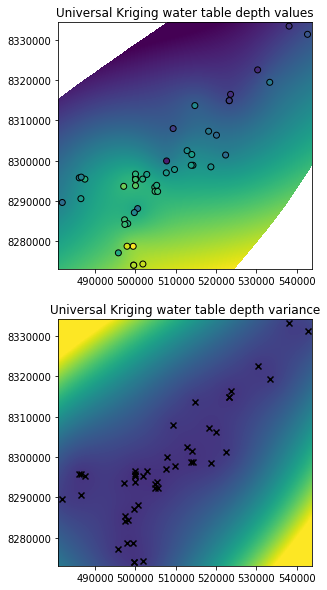

In [18]:
# plot the results for the Universal kriging Kriging
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (40,10))

# Mask the array
swl_results = np.copy(zu.data)

swl_results[masku] = np.nan

ax1.imshow(swl_results, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0., vmax = 16.)

ax2.imshow(ssu.data, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0, vmax = 30.)

ax1.scatter(X,Y, c = swl, vmin = 0, vmax = 16., edgecolors = 'k')
ax2.scatter(X,Y,marker = 'x', color = 'k', linewidths = 0.1)

ax1.set_title("Universal Kriging water table depth values")
ax2.set_title("Universal Kriging water table depth variance")

plt.show()

This result is better but still far to smooth. Ideally we would like a water table surface that is consistent with auxillary datasets. It is well documented that there is a strong correlation between water table elevation and ground elevatoin for interconnected systems.


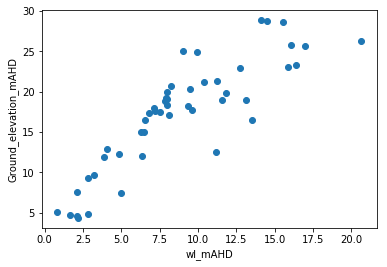

In [20]:
# To demonstrate the relationship between the groundwater elevation and ground elevation we 
# run a scatter plot


plt.scatter(df_swl['wl_mAHD'].values,
           df_swl['Ground_elevation_mAHD'].values)

plt.xlabel('wl_mAHD')
plt.ylabel('Ground_elevation_mAHD')

plt.show()

While there is some scatter here the trend is clearly linear. Our next attempt is to model the water table using regression kriging.

In [21]:
# Create a new grid using the extents of the boehole data we are modelling
X = bore_coords[:,0]
Y = bore_coords[:,1]

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 50)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 50)[::-1]

# WE are going to interpolate elevatoin data onto this grid using the lidar
tif_file = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\LiDAR\LiDAR_final\EK_LiDAR_cubic_10x10.tif'

# Define the temporary output for the grid

elev_outfile = r"C:\temp\lidar_elev_50m.tif"

# Create the new file
spatial_functions.resample_raster(tif_file, elev_outfile, gridx, gridy, driver='GTiff',
                 null = -9999)

# WE are going to interpolate slope data
tif_file = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\LiDAR\LiDAR_final\EK_LiDAR_slope_cubic_10x10.tif'

# Define the temporary output for the grid

slope_outfile = r"C:\temp\lidar_slope_50m.tif"

# Create the new file
spatial_functions.resample_raster(tif_file, slope_outfile, gridx, gridy, driver='GTiff',
                 null = -9999)

In [22]:
# Open the new file
elev_src = rasterio.open(elev_outfile)

# Iterator yielding the nearest neighbour
vals = elev_src.sample(bore_coords)

# Add the 50 m grid elevation to the dataframe
df_swl['lid50m_elevation_mAHD'] = np.nan

for index, row in df_swl.iterrows():

    df_swl.at[index, 'lid50m_elevation_mAHD'] = next(vals)[0]

# Open the new file
slope_src = rasterio.open(slope_outfile)

# Iterator yielding the nearest neighbour
vals = slope_src.sample(bore_coords)

# Add the 50 m grid slope to the dataframe
df_swl['lid50m_slope'] = np.nan

# Iterate through the rows
for index, row in df_swl.iterrows():

    df_swl.at[index, 'lid50m_slope'] = next(vals)[0]
    


In [23]:
len(df_swl)

48

In [24]:
# Drop rows with no lidar elevation, they are not useful to us
# for regression kriging

df_swl = df_swl[~np.isnan(df_swl['lid50m_elevation_mAHD'])]

In [25]:
len(df_swl)

46

In [26]:
df_swl

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,wl_mAHD,lid50m_elevation_mAHD,lid50m_slope
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,901,6.301,14.849471,0.322045
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,548,4.831,12.148163,0.913838
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,902,7.927,19.119029,0.195385
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,900,3.898,11.985136,0.171667
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,900,4.079,12.900905,0.148205
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,900,7.220,17.520233,0.104250
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,901,2.806,9.333680,0.131756
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,555,13.132,18.973789,0.202954
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,554,14.133,28.846032,0.191896
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,148,2.079,8.340292,0.378587


In [26]:
# Now lets try runnning a regression on these values by building a model
# to estimate water table elevation from from groundelevation

# Define model variables
p = df_swl['lid50m_elevation_mAHD'].values.reshape([-1,1])
#p = df_swl[['lid50m_elevation_mAHD', 'lid50m_slope']].values
x = df_swl[['Easting', 'Northing']].values
target = df_swl['wl_mAHD'].values


from sklearn.linear_model import LinearRegression

# As above we will use a linear model

ridge_model = Ridge().fit(p, target)

scores = cross_val_score(ridge_model, p, target, cv=5, scoring = 'explained_variance')

print("Ridge regression model cross-validation score: ", ridge_model.score(p, target))

linear_regression = LinearRegression().fit(p, target)

scores = cross_val_score(linear_regression, p, target, cv=5, scoring = 'explained_variance')

print("Linear regression model cross-validation score: ", np.mean(scores))


Ridge regression model cross-validation score:  0.7203016070171157
Linear regression model cross-validation score:  0.6095741905062084


It appears we do get a better model by regularising with ridge regression so we will use this in our model building and prediciton

In [27]:
# Build the regression kriging estimator
m_rk = RegressionKriging(regression_model=ridge_model, n_closest_points=8,
                            method='ordinary',variogram_model='linear')

regression_var_explained = 0.
regression_kriging_score = 0.

nruns = 100

# We run 100 models
for i in range(nruns):
    # Split the model into testing and training randomly
    p_train, p_test, x_train, x_test, target_train, target_test \
                = train_test_split(p, x, target,
                                   test_size=0.3, 
                                   random_state=i)


    m_rk.fit(p_train, x_train, target_train)
            
    regression_kriging_score += (m_rk.regression_model.score(p_test, target_test))
    
    regression_var_explained += explained_variance_score(m_rk.predict(p_test, x_test), target_test)
        

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [28]:
# Print statistics about the run. This can be used to 'optimise' kriging parameters

print('Regression kriging score: ', np.sum(regression_kriging_score)/float(nruns))
print('Variance explained score: ', np.sum(regression_var_explained)/float(nruns))

Regression kriging score:  0.6316560496562471
Variance explained score:  0.5764922761203625


In [29]:
# Now train the model on all the data

m_rk.fit(p, x, target)


Finished learning regression model
Finished kriging residuals


In [30]:
# Lets prepare a model for the ridge regression

xv, yv = np.meshgrid(gridx, gridy)



elevations = elev_src.read()[0]
slopes = slope_src.read()[0]

# Do some processing to remove bad values
elevations[elevations < -900] = np.nan
slopes[slopes < -900] = np.nan

# Create an empty array into which to save our 
# predicted values

predicted = np.nan*np.ones(shape = elevations.shape,
                           dtype = np.float32)

mask = np.isfinite(elevations) & np.isfinite(slopes)

predict_coords = np.hstack((xv[mask].reshape([-1,1]),
                            yv[mask].reshape([-1,1])))


#predict_vars = np.hstack((elevations[mask].reshape([-1,1]),
#                           slopes[mask].reshape([-1,1])))

predict_vars = elevations[mask].reshape([-1,1])

In [31]:
# Predict using regression kriging
import time

start_time = time.time()

pred = m_rk.predict(predict_vars, predict_coords)


print("Prediction completed after ", str(time.time() - start_time), " seconds")

Prediction completed after  170.518000125885  seconds


In [32]:
# Update the predicted grid values using our mask
predicted[mask] = pred

# REshape the grid back to 2 dimensions
grid = predicted.reshape(elevations.shape)

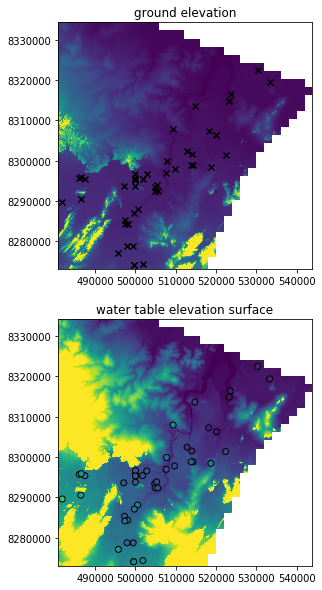

In [33]:
# plot the results
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (40,10))

# Mask the array


ax1.imshow(elevations, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0., vmax = 200.)

ax2.imshow(grid, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0, vmax = 30.)

# Add bores to the diagrams

X = x[:,0]
Y = x[:,1]

# Scatter with the same colourscheme as the grids
ax2.scatter(X,Y, c = target, vmin = 0, vmax = 30., edgecolors = 'k')
ax1.scatter(X,Y,marker = 'x', color = 'k', linewidths = 0.1)

ax1.set_title("ground elevation")
ax2.set_title("water table elevation surface")
plt.show()

In [34]:
# Output a tiff for assessing in a GIS

# Get affine and crs from elevation raster
affine = elev_src.transform

crs = elev_src.crs

outfile = r"C:\temp\water_table_map_.tif"

new_dataset = rasterio.open(outfile, 'w', driver="GTiff",
                                height=grid.shape[0], width=grid.shape[1],
                                count=1, dtype=grid.dtype,
                                crs=crs, transform=affine)
new_dataset.write(grid, 1)

new_dataset.close()

In [13]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"

and

            within(s.geom,GeomFromText('{}'));""".format(OrdKeep)

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="min")]



In [14]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )


In [15]:
df_inversions.head(24)

,Depth_from,Depth_to,Mobile_water_content,Bound_water_content,Total_water_content,T2*,acquisition_id,inversion_id,site_id,Field_ID,mid_X,mid_Y,pulse_sequence,pulse_length,Depth_of_Investigation
table_id,,,,,,,,,,,,,,,
2300,0.424358,0.584135,0.090960,0.108165,0.199125,0.021730,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2301,0.584135,0.779694,0.114902,0.244187,0.359089,0.015200,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2302,0.779694,1.014651,0.094979,0.121004,0.215983,0.021756,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2303,1.014651,1.292620,0.000000,0.000000,0.000000,2.408116,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2304,1.292620,1.617217,0.176056,0.377310,0.553366,0.018704,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2305,1.617217,1.992058,0.037486,0.109043,0.146529,2.999998,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2306,1.992058,2.420758,0.014329,0.074370,0.088699,2.999957,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2307,2.420758,2.906933,0.054042,0.000000,0.054042,2.999992,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173
2308,2.906933,3.454198,0.000000,0.000000,0.000000,0.181596,48,46,37,WANT_t1_S6,499969.965,8289545.684,FID,60.0,72.629173


In [16]:
# Now we want to discover any colocated sites

SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(bore_coords,
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)


In [17]:
df_swl['co-located_SNMR_site_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_swl.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Sincve we only have one acquisition per site we can use site_id
        df_swl.at[index, 'co-located_SNMR_site_id'] = df_acquisitions['site_id'].iloc[idx]

In [18]:
df_swl

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,wl_mAHD,co-located_SNMR_site_id
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,901,6.301,-999
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,548,4.831,-999
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,902,7.927,263
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,900,3.898,-999
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,900,4.079,78
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,900,7.220,-999
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,901,2.806,-999
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,555,13.132,-999
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,554,14.133,-999
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,148,2.079,233


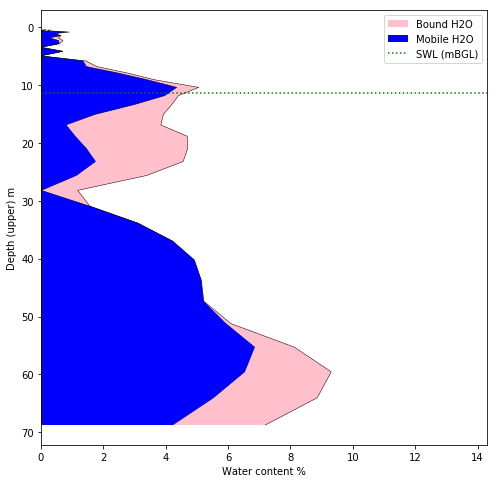

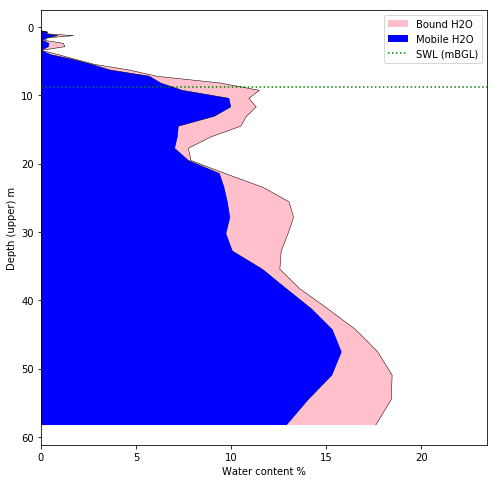

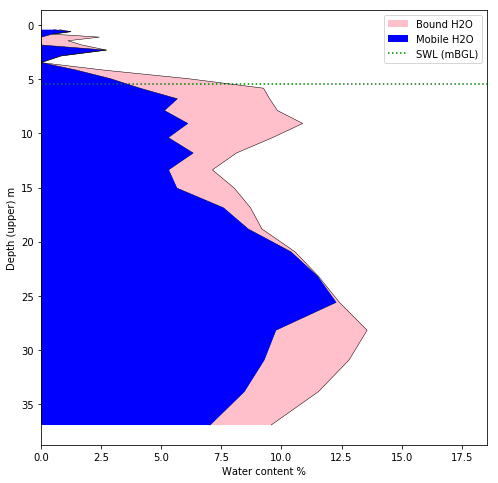

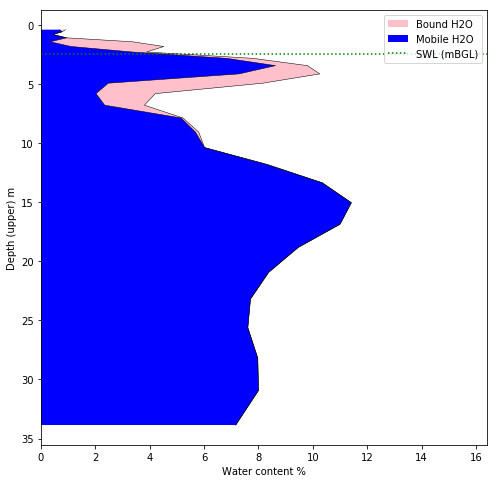

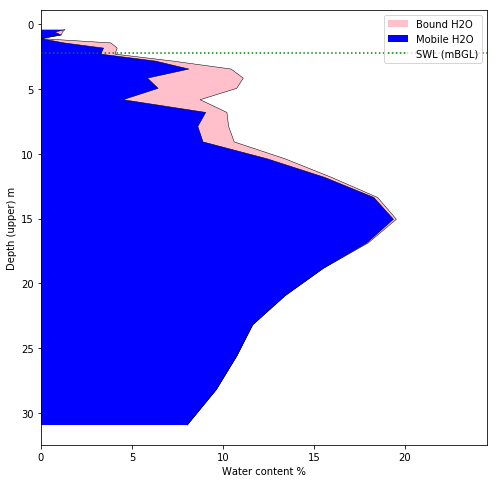

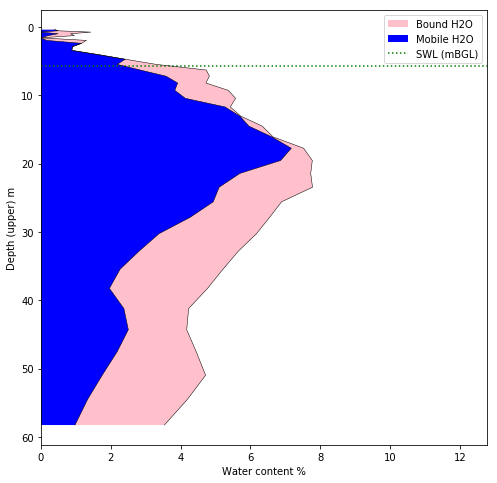

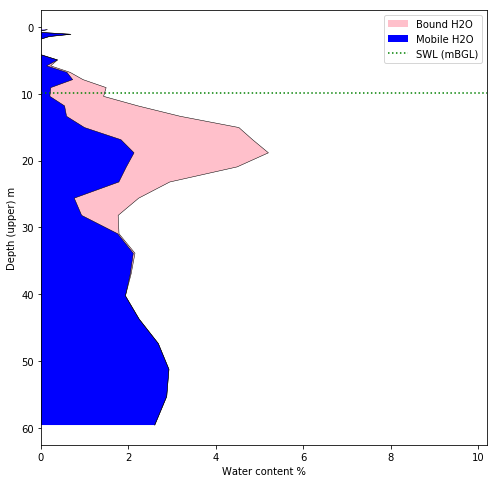

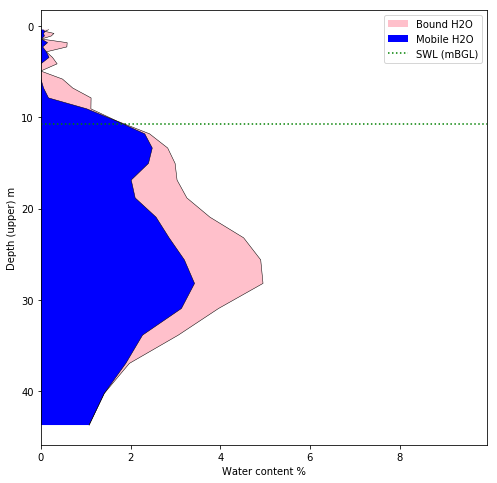

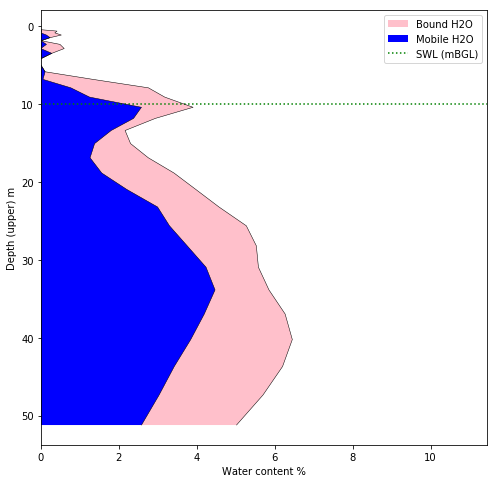

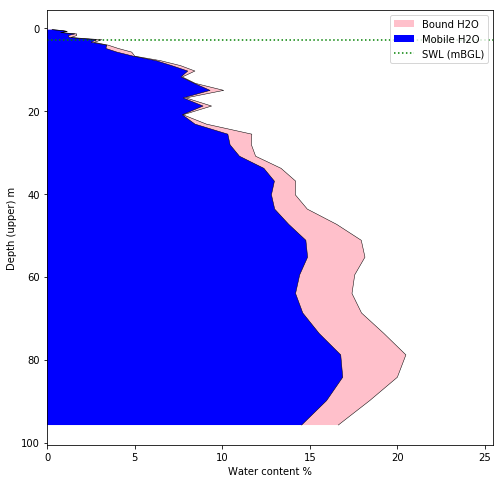

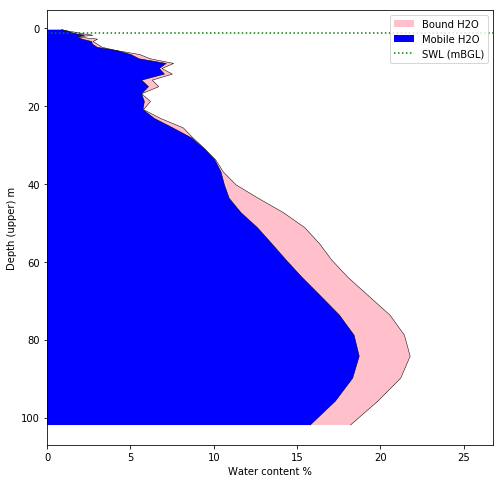

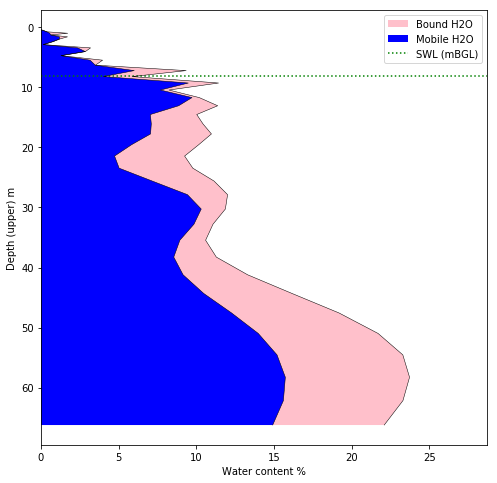

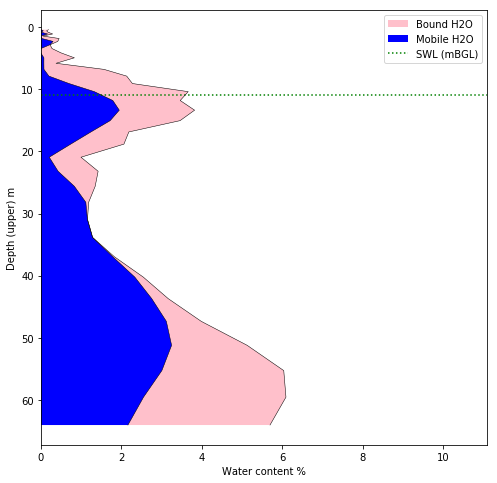

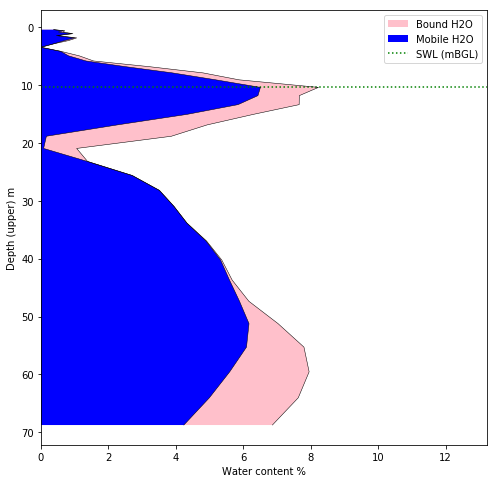

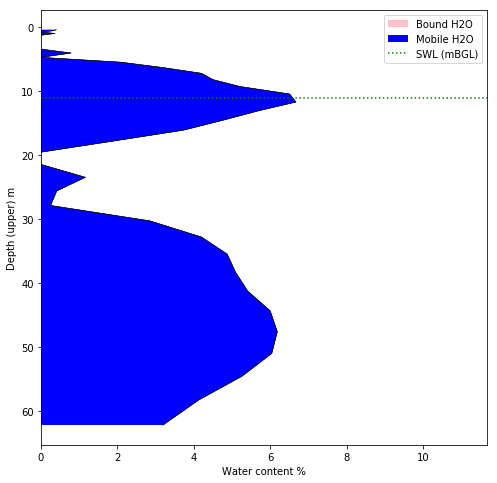

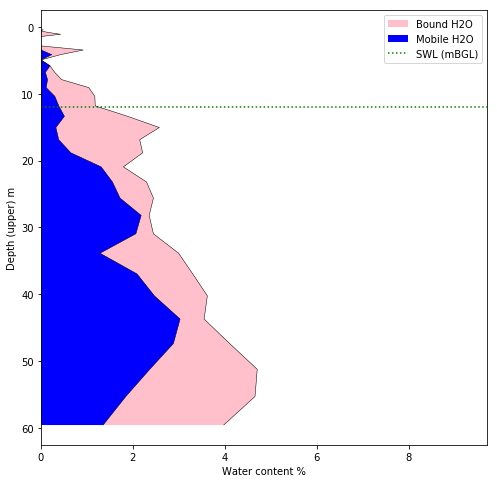

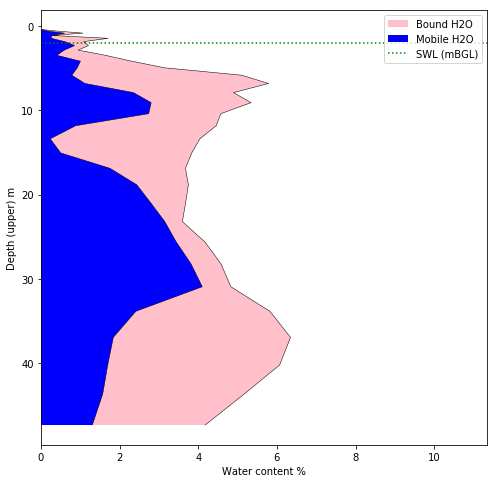

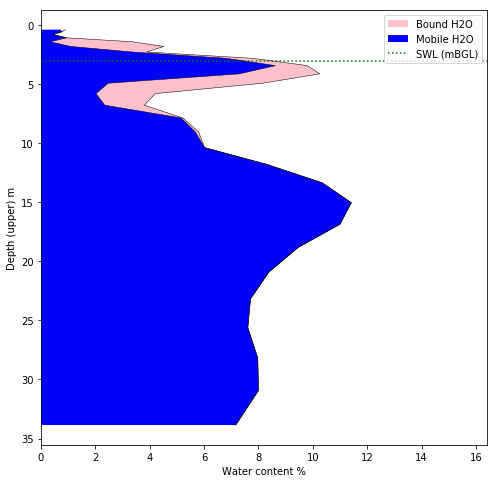

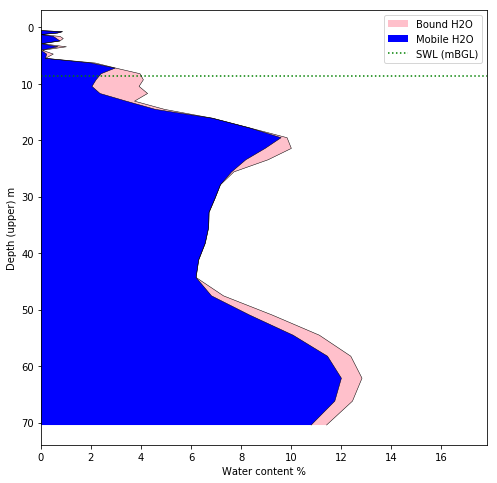

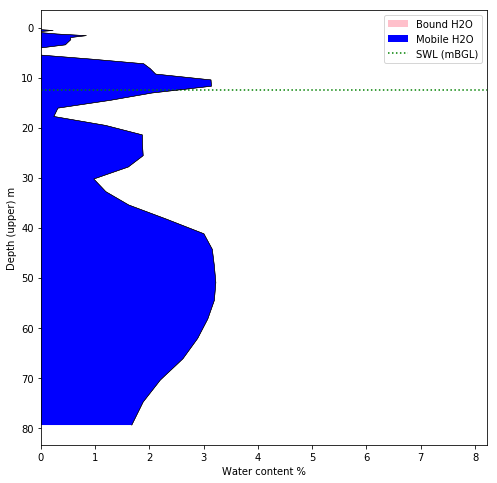

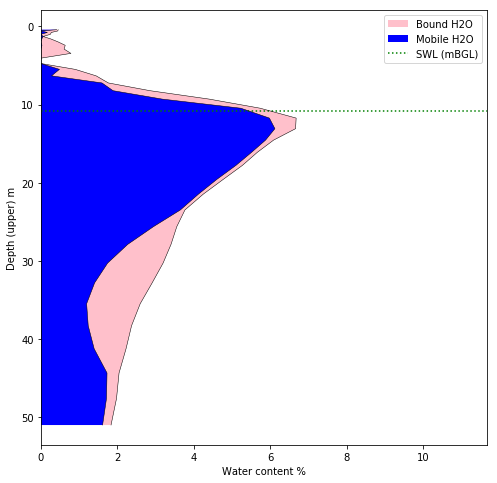

In [19]:
# For each bore with a standing water level plot
# the level on a plot of water level

mask = df_swl['co-located_SNMR_site_id'] != -999

df_swl_subset = df_swl[mask]

# Define outdir

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\plots"


for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    swl_depth = row['SWL_depth']
    
    field_id = df_acquisitions[df_acquisitions['site_id'] == site_id]['Field_ID'].values[0]
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(swl_depth, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted', label = 'SWL (mBGL)')
    
    ax.legend()

    
    fname = row['Borehole_name'] + '_' + field_id + "_comparison_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    
    

In [220]:
# Calculate key attributes for the optimisation exercise

# Find the mean and standard deviation of a moving window for the mobile water

new_cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id',
       'site_id', 'Field_ID', 'mid_X', 'mid_Y', 'pulse_sequence',
       'pulse_length', 'Depth_of_Investigation',
       'Total_water_content_zero_mean', 'Total_water_content_CV_4',
       'Total_water_content_gradient_4', 'Total_water_content_CV_6',
       'Total_water_content_gradient_6', 'Total_water_content_CV_8',
       'Total_water_content_gradient_8', 'Mobile_water_content_zero_mean',
       'Mobile_water_content_CV_4', 'Mobile_water_content_gradient_4',
       'Mobile_water_content_CV_6', 'Mobile_water_content_gradient_6',
       'Mobile_water_content_CV_8', 'Mobile_water_content_gradient_8',
       'saturated']

df_SNMR_params = pd.DataFrame(columns = new_cols)

window_size = [2,4,6,8]

parameters = ['Total_water_content', 'Mobile_water_content']

for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    swl = row['SWL_depth']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    
    # Since we are only intereseted in the top 40 metres or so lets filter the 
    # data frame for the near surface
    SNMR_inversion =  SNMR_inversion[ SNMR_inversion['Depth_to'] < 40.]
    
    # Iterate through the metrixcs
    for param in parameters:
        
        a = SNMR_inversion[param]
    
        # Get mean-zero water content
        SNMR_inversion[param + '_zero_mean'] = a - np.mean(a)
        
        for wind in window_size:
        # Calculate the rolling mean
            rolling_mean = a.rolling(wind,
                                     min_periods = 1).mean()  + 0.001 # Guard agianst dividing by 0
            rolling_std = a.rolling(wind, 
                                    min_periods = 1).std()
            # Coefficient of variation
            SNMR_inversion[param + '_CV' + '_' + str(wind)] = np.divide(rolling_std, rolling_mean)
            
            # Get the gradient
            SNMR_inversion[param + '_gradient' + '_' + str(wind)] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                                                      window=wind).mean())
            
    
    # Add a label for saturated or no or transition (0.5)
    SNMR_inversion['saturated'] = 0.5
    
    # All values above the water table labeled as unsaturated
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_to'] < swl].index, 'saturated'] = 0
    
    SNMR_inversion.at[SNMR_inversion[SNMR_inversion['Depth_from'] > swl].index, 'saturated'] = 1
    
    
    df_SNMR_params = df_SNMR_params.append(SNMR_inversion).dropna()

df_training = df_SNMR_params[df_SNMR_params['saturated'] != 0.5]

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


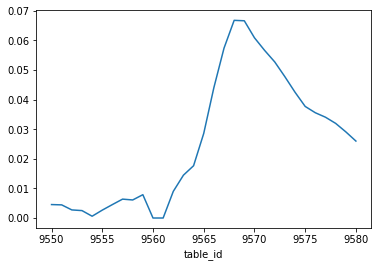

In [223]:
SNMR_inversion['Total_water_content'].plot()

In [205]:
df_training

,Bound_water_content,Depth_from,Depth_of_Investigation,Depth_to,Field_ID,Mobile_water_content,Mobile_water_content_CV_2,Mobile_water_content_CV_4,Mobile_water_content_CV_6,Mobile_water_content_CV_8,...,Total_water_content_gradient_8,Total_water_content_zero_mean,acquisition_id,inversion_id,mid_X,mid_Y,pulse_length,pulse_sequence,saturated,site_id
20452,0.001309,0.823463,71.189093,1.102440,OK18_76,0.007840,1.005164e+00,9.212940e-01,0.921294,0.921294,...,0.001007,-0.012858,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20453,0.000002,1.102440,71.189093,1.438227,OK18_76,0.004123,3.765553e-01,7.238153e-01,0.723815,0.723815,...,0.000101,-0.017882,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20454,0.000021,1.438227,71.189093,1.836089,OK18_76,0.006448,2.615922e-01,5.607476e-01,0.611578,0.611578,...,0.000243,-0.015539,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20455,0.002998,1.836089,71.189093,2.301292,OK18_76,0.002697,4.760293e-01,3.671572e-01,0.585183,0.585183,...,0.000200,-0.016313,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20456,0.001356,2.301292,71.189093,2.839100,OK18_76,0.005731,4.115287e-01,2.919887e-01,0.482235,0.524775,...,0.000179,-0.014920,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20457,0.000142,2.839100,71.189093,3.454777,OK18_76,0.005852,1.266224e-02,2.727734e-01,0.279947,0.479993,...,-0.000149,-0.016013,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20458,0.000000,3.454777,71.189093,4.153590,OK18_76,0.000000,1.054016e+00,6.109580e-01,0.476496,0.554258,...,0.000116,-0.022007,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20459,0.000005,4.153590,71.189093,4.940802,OK18_76,0.007069,1.102323e+00,5.592099e-01,0.483811,0.432992,...,-0.000269,-0.014933,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20460,0.000000,4.940802,71.189093,5.821679,OK18_76,0.000000,1.102323e+00,8.895169e-01,0.682381,0.564548,...,0.000074,-0.022007,417,409,500099.6412,8295239.253,80.0,FID,0.0,263
20461,0.000934,5.821679,71.189093,6.801485,OK18_76,0.013523,1.232002e+00,1.057610e+00,0.793336,0.713306,...,0.001370,-0.007550,417,409,500099.6412,8295239.253,80.0,FID,0.0,263


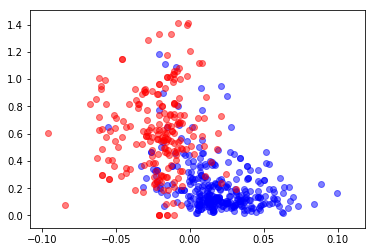

In [207]:
# Scatter plot the zero meaned and coefficient of variation

fig, ax1 = plt.subplots(1,1)

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax1.scatter(saturated['Total_water_content_zero_mean'].values, saturated['Total_water_content_CV_4'].values,
           c= 'blue', alpha = 0.5)
ax1.scatter(unsaturated['Total_water_content_zero_mean'].values, unsaturated['Total_water_content_CV_4'].values,
           c= 'red', alpha = 0.5)

plt.show()

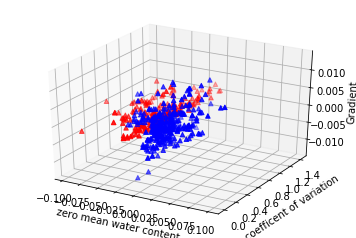

In [208]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

saturated = df_SNMR_params[df_SNMR_params['saturated'] == 1.]
unsaturated = df_SNMR_params[df_SNMR_params['saturated'] == 0.]

ax.scatter(saturated['Total_water_content_zero_mean'].values,
           saturated['Total_water_content_CV_4'].values,
           saturated['Total_water_content_gradient_8'].values, c = 'blue', marker = '^')
           

ax.scatter(unsaturated['Total_water_content_zero_mean'].values,
           unsaturated['Total_water_content_CV_4'].values,
           unsaturated['Total_water_content_gradient_8'].values, c = 'red', marker = '^')

ax.set_xlabel('zero mean water content')
ax.set_ylabel('coefficent of variation')
ax.set_zlabel('Gradient')

plt.show()

In [224]:
# Train a classifier on this to get probability of saturation given
# the zero mean, coefficient of variation and gradient

# WE ignore the transition zone so it is a binary classification

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

train_cols = ['Total_water_content_zero_mean',
             'Total_water_content_gradient_8',
             'Total_water_content_CV_6',
             'Total_water_content']



X = df_training[train_cols].values
y = df_training['saturated'].astype(int).values

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75,
                                                    test_size=0.25, shuffle=True)

# WE use tpot to pick the best pipeline

tpot = TPOTClassifier(verbosity=2, max_time_mins=3)

tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.9623101265822784
Generation 2 - Current best internal CV score: 0.9623101265822784
Generation 3 - Current best internal CV score: 0.9672784810126581

3.15755 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(BernoulliNB(input_matrix, alpha=10.0, fit_prior=True), learning_rate=1.0, max_depth=8, max_features=0.9500000000000001, min_samples_leaf=18, min_samples_split=5, n_estimators=100, subsample=0.8500000000000001)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=1000000,
        max_eval_time_mins=5, max_time_mins=3, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [227]:
# Test the classifier on the test set

tpot.score(X_test, y_test)
tpot.export(r"C:\temp\tpot_mnist_pipeline.py")

# This is a good score

In [229]:
# Now we trial a few combinations of parameters, we will 
# judge the results by the cross validation score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

# Define the three variables

for par in parameters:
    # Window size for the gradient variables
    for gradient_wind in window_size:
        for cv_wind in window_size:
            # Define columns and extract data
            cols = [par + '_zero_mean', par + '_gradient_' + str(gradient_wind),
                   par + '_CV_' + str(cv_wind), par]
            X = df_training[cols].values
            y = df_training['saturated'].astype(int).values
            clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                             max_features=0.05, min_samples_leaf=4,
                                             min_samples_split=10, n_estimators=100, subsample=0.25)
            
            # Cross validation
            try:
                cv_results = cross_validate(clf, X, y, cv=5, return_train_score=False)
                print(cols)
                print(np.mean(cv_results['test_score']))
            except ValueError:
                pass

        


['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_2', 'Total_water_content']
0.9113000982441999
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_4', 'Total_water_content']
0.9263947737444476
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_6', 'Total_water_content']
0.9452637059055681
['Total_water_content_zero_mean', 'Total_water_content_gradient_2', 'Total_water_content_CV_8', 'Total_water_content']
0.934013485485889
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_2', 'Total_water_content']
0.9208059383160776
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_4', 'Total_water_content']
0.9339422794333745
['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_6', 'Total_water_content']
0.9490549243855538
['Total_water_content_zero_mean', '

In [230]:
cols = ['Total_water_content_zero_mean', 'Total_water_content_gradient_4', 'Total_water_content_CV_6',
       'Total_water_content']

X = df_training[cols].values

y = df_training['saturated'].astype(int).values

clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,
                                 max_features=0.05, min_samples_leaf=4,
                                 min_samples_split=10, n_estimators=100, subsample=0.25)

clf.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=0.05, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.25, verbose=0,
              warm_start=False)

In [231]:
cols

['Total_water_content_zero_mean',
 'Total_water_content_gradient_4',
 'Total_water_content_CV_6',
 'Total_water_content']

In [233]:
# Now lets use this to predict the rest of our SNMR soundings

# Cut out only the top 40 metres

df_inversions = df_inversions[df_inversions['Depth_to'] < 40.]


# Find the mean and standard deviation of a moving window for the mobile water

for site in df_inversions.site_id.unique():

    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site]
    
    # Iterate through the metrixcs
    a = SNMR_inversion['Total_water_content']
    
    # Get mean-zero water content
    SNMR_inversion['Total_water_content_zero_mean'] = a - np.mean(a)
    
    # Get the optimal gradient
    # Calculate the rolling mean
    rolling_mean = a.rolling(6, min_periods = 1).mean() + 0.001 # Guard agianst dividing by 0
    rolling_std = a.rolling(6, min_periods = 1).std()
    
    # Calculate coefficient of variation
    SNMR_inversion['Total_water_content_CV'] = np.divide(rolling_std, rolling_mean)
            
    # Get the gradient
    SNMR_inversion['Total_water_content_gradient'] = np.gradient(a.rolling(center=False, min_periods = 2,
                                                                           window=4).mean())
    SNMR_inversion = SNMR_inversion.dropna()
    
    # Now predict the saturation of the profile
    X = SNMR_inversion[['Total_water_content_zero_mean',
                        'Total_water_content_gradient',
                        'Total_water_content_CV',
                        'Total_water_content']]
    
    pred = clf.predict(X)
    
    pred_prob =clf.predict_proba(X)
    # Get the optimal change point
    
    print(site)
    print(pred_prob)
    print(pred)
    
    idx = find_optimal_index(pred_prob)
    
    # Estimate the water table at each site
    water_table = SNMR_inversion['Depth_from'].iloc[idx]
    
    # Add to the acquisitions dataframe
    ind = df_acquisitions[df_acquisitions['site_id'] == site].index
    
    df_acquisitions.at[ind, 'modelled_water_table'] = water_table

    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

37
[[1.58711942e-02 9.84128806e-01]
 [9.97323055e-01 2.67694495e-03]
 [9.36694155e-03 9.90633058e-01]
 [1.16998039e-01 8.83001961e-01]
 [1.42964768e-01 8.57035232e-01]
 [4.58111640e-02 9.54188836e-01]
 [1.27754630e-01 8.72245370e-01]
 [9.51143465e-01 4.88565354e-02]
 [2.44408436e-02 9.75559156e-01]
 [2.44408436e-02 9.75559156e-01]
 [2.61083607e-02 9.73891639e-01]
 [2.55854553e-03 9.97441454e-01]
 [5.68062577e-01 4.31937423e-01]
 [8.71625367e-05 9.99912837e-01]
 [1.85863634e-01 8.14136366e-01]
 [1.50391998e-03 9.98496080e-01]
 [8.43601975e-04 9.99156398e-01]
 [1.15115521e-01 8.84884479e-01]
 [9.67862103e-03 9.90321379e-01]
 [2.62084617e-04 9.99737915e-01]
 [8.67033049e-05 9.99913297e-01]
 [9.13671766e-05 9.99908633e-01]
 [5.53603270e-05 9.99944640e-01]
 [5.91483591e-01 4.08516409e-01]
 [1.15115521e-01 8.84884479e-01]
 [3.18087952e-03 9.96819120e-01]
 [1.11351379e-03 9.98886486e-01]
 [9.41917431e-04 9.99058083e-01]
 [1.08425138e-03 9.98915749e-01]]
[1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 

 [2.03225173e-05 9.99979677e-01]]
[1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
76
[[9.99439494e-01 5.60505528e-04]
 [9.98517951e-01 1.48204872e-03]
 [9.99619202e-01 3.80797949e-04]
 [9.98999306e-01 1.00069415e-03]
 [9.93837983e-01 6.16201662e-03]
 [9.97555686e-01 2.44431413e-03]
 [9.87780898e-01 1.22191017e-02]
 [9.98910486e-01 1.08951438e-03]
 [9.96162135e-01 3.83786545e-03]
 [9.96948183e-01 3.05181704e-03]
 [5.65602240e-01 4.34397760e-01]
 [9.57288290e-02 9.04271171e-01]
 [5.27787066e-03 9.94722129e-01]
 [2.07236594e-04 9.99792763e-01]
 [1.12861249e-04 9.99887139e-01]
 [2.97832415e-05 9.99970217e-01]
 [3.83116873e-05 9.99961688e-01]
 [1.35437827e-04 9.99864562e-01]
 [1.05766874e-03 9.98942331e-01]
 [8.51288520e-03 9.91487115e-01]
 [4.08768008e-02 9.59123199e-01]
 [9.05856462e-04 9.99094144e-01]
 [1.63512995e-03 9.98364870e-01]
 [8.30706724e-03 9.91692933e-01]
 [3.65910835e-05 9.99963409e-01]
 [6.29344732e-05 9.99937066e-01]
 [3.34668322e-05 9.99966533e-01]
 [2.69141036e-

 [6.11103076e-05 9.99938890e-01]]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
85
[[9.80235656e-01 1.97643444e-02]
 [9.98791072e-01 1.20892834e-03]
 [9.98524774e-01 1.47522557e-03]
 [9.98777477e-01 1.22252267e-03]
 [9.99569581e-01 4.30418991e-04]
 [9.99913687e-01 8.63128478e-05]
 [9.99159876e-01 8.40124244e-04]
 [9.99832299e-01 1.67700895e-04]
 [9.98540528e-01 1.45947165e-03]
 [9.84343352e-01 1.56566477e-02]
 [8.53422190e-01 1.46577810e-01]
 [9.19156776e-01 8.08432237e-02]
 [4.90717931e-01 5.09282069e-01]
 [2.45113280e-04 9.99754887e-01]
 [2.54155926e-03 9.97458441e-01]
 [1.77672776e-03 9.98223272e-01]
 [1.48246199e-03 9.98517538e-01]
 [2.09363853e-04 9.99790636e-01]
 [1.17996332e-04 9.99882004e-01]
 [3.69081688e-05 9.99963092e-01]
 [4.21556526e-05 9.99957844e-01]
 [2.51863579e-05 9.99974814e-01]
 [1.82300025e-05 9.99981770e-01]
 [2.37922007e-04 9.99762078e-01]
 [1.53078471e-04 9.99846922e-01]
 [1.49638408e-04 9.99850362e-01]
 [1.68720695e-04 9.99831279e-01]
 [1.68720695

 [5.12432333e-05 9.99948757e-01]]
[1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
94
[[9.14469733e-01 8.55302671e-02]
 [9.99140853e-01 8.59146844e-04]
 [9.83995696e-01 1.60043043e-02]
 [9.57138839e-01 4.28611609e-02]
 [9.97739769e-01 2.26023103e-03]
 [9.93557552e-01 6.44244810e-03]
 [9.00563459e-01 9.94365407e-02]
 [1.67997571e-01 8.32002429e-01]
 [1.34648276e-02 9.86535172e-01]
 [3.30110440e-03 9.96698896e-01]
 [2.99348846e-03 9.97006512e-01]
 [3.15747420e-04 9.99684253e-01]
 [1.21652559e-04 9.99878347e-01]
 [5.32670598e-05 9.99946733e-01]
 [9.39509227e-05 9.99906049e-01]
 [3.32148745e-04 9.99667851e-01]
 [1.54622739e-04 9.99845377e-01]
 [5.90062980e-05 9.99940994e-01]
 [4.32817484e-05 9.99956718e-01]
 [4.29043030e-05 9.99957096e-01]
 [5.12897003e-05 9.99948710e-01]
 [5.13148539e-05 9.99948685e-01]
 [2.35162612e-05 9.99976484e-01]
 [3.04389571e-05 9.99969561e-01]
 [4.00836062e-05 9.99959916e-01]
 [5.33078779e-05 9.99946692e-01]
 [5.53171619e-05 9.99944683e-01]
 [4.37103046

 [6.03155229e-05 9.99939684e-01]]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
102
[[9.61783192e-01 3.82168083e-02]
 [9.90261638e-01 9.73836180e-03]
 [9.99209217e-01 7.90783163e-04]
 [9.99008035e-01 9.91964631e-04]
 [9.99306762e-01 6.93237733e-04]
 [9.99179680e-01 8.20320132e-04]
 [9.89453679e-01 1.05463207e-02]
 [9.99189426e-01 8.10573891e-04]
 [9.96142227e-01 3.85777307e-03]
 [9.97480682e-01 2.51931776e-03]
 [9.94342171e-01 5.65782871e-03]
 [9.79268825e-01 2.07311747e-02]
 [9.91440866e-01 8.55913412e-03]
 [6.04813094e-02 9.39518691e-01]
 [2.66009736e-03 9.97339903e-01]
 [1.37912037e-03 9.98620880e-01]
 [1.50248084e-04 9.99849752e-01]
 [1.35837120e-04 9.99864163e-01]
 [1.72549292e-04 9.99827451e-01]
 [1.87188402e-05 9.99981281e-01]
 [3.25287524e-05 9.99967471e-01]
 [5.92095841e-05 9.99940790e-01]
 [5.18977848e-05 9.99948102e-01]
 [3.46355332e-04 9.99653645e-01]
 [8.28478224e-05 9.99917152e-01]
 [1.49647916e-04 9.99850352e-01]
 [6.56059286e-05 9.99934394e-01]
 [2.2712712

 [7.13897546e-05 9.99928610e-01]]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
110
[[9.97880989e-01 2.11901072e-03]
 [9.99853461e-01 1.46539339e-04]
 [9.99659559e-01 3.40440608e-04]
 [9.87608581e-01 1.23914187e-02]
 [9.98644600e-01 1.35539954e-03]
 [9.91542990e-01 8.45701018e-03]
 [6.54781062e-01 3.45218938e-01]
 [1.03149744e-01 8.96850256e-01]
 [8.36651824e-02 9.16334818e-01]
 [3.54682290e-03 9.96453177e-01]
 [5.77228096e-05 9.99942277e-01]
 [5.52926189e-05 9.99944707e-01]
 [1.96158357e-04 9.99803842e-01]
 [2.58532769e-05 9.99974147e-01]
 [3.53025152e-05 9.99964697e-01]
 [5.34285083e-05 9.99946571e-01]
 [6.31780167e-05 9.99936822e-01]
 [3.38105682e-05 9.99966189e-01]
 [6.34656877e-05 9.99936534e-01]
 [1.42955077e-04 9.99857045e-01]
 [1.42167834e-04 9.99857832e-01]
 [7.55183243e-04 9.99244817e-01]
 [7.49300190e-05 9.99925070e-01]
 [4.49393961e-05 9.99955061e-01]
 [1.29917463e-05 9.99987008e-01]
 [3.77439178e-04 9.99622561e-01]
 [1.74581408e-04 9.99825419e-01]
 [1.9048635

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
118
[[9.87943324e-01 1.20566759e-02]
 [9.65893603e-01 3.41063968e-02]
 [5.44850249e-01 4.55149751e-01]
 [7.77600117e-01 2.22399883e-01]
 [6.15604795e-01 3.84395205e-01]
 [5.28334977e-01 4.71665023e-01]
 [2.67224563e-01 7.32775437e-01]
 [1.06645303e-01 8.93354697e-01]
 [4.87691527e-01 5.12308473e-01]
 [1.51296052e-03 9.98487039e-01]
 [1.02327753e-03 9.98976722e-01]
 [1.95595706e-04 9.99804404e-01]
 [6.04672469e-05 9.99939533e-01]
 [1.86489945e-04 9.99813510e-01]
 [2.20147440e-04 9.99779853e-01]
 [3.00718280e-04 9.99699282e-01]
 [1.79778938e-04 9.99820221e-01]
 [1.68230404e-05 9.99983177e-01]
 [3.30936190e-05 9.99966906e-01]
 [5.78678053e-05 9.99942132e-01]
 [6.28626276e-05 9.99937137e-01]
 [5.12897003e-05 9.99948710e-01]
 [5.12987259e-05 9.99948701e-01]
 [5.12897003e-05 9.99948710e-01]
 [5.54986738e-05 9.99944501e-01]
 [6.76945484e-05 9.99932305e-01]
 [5.13185635e-05 9.99948681e-01]
 [3.99303218e-05 9.99960070e-01]
 [3.92910388e-

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
126
[[9.99326269e-01 6.73730937e-04]
 [9.45595359e-01 5.44046411e-02]
 [9.97318969e-01 2.68103074e-03]
 [9.89227456e-01 1.07725439e-02]
 [9.81263555e-01 1.87364453e-02]
 [9.92967072e-01 7.03292798e-03]
 [9.42679790e-01 5.73202100e-02]
 [8.05722524e-01 1.94277476e-01]
 [9.98033975e-01 1.96602524e-03]
 [9.97223632e-01 2.77636813e-03]
 [9.98733358e-01 1.26664240e-03]
 [9.98958434e-01 1.04156631e-03]
 [6.50018963e-01 3.49981037e-01]
 [7.61297194e-01 2.38702806e-01]
 [9.63678267e-01 3.63217334e-02]
 [2.30069640e-01 7.69930360e-01]
 [2.31444164e-03 9.97685558e-01]
 [9.06344935e-05 9.99909366e-01]
 [4.66750008e-05 9.99953325e-01]
 [9.11910900e-05 9.99908809e-01]
 [1.73696589e-04 9.99826303e-01]
 [2.86821592e-04 9.99713178e-01]
 [7.28077240e-04 9.99271923e-01]
 [1.02304265e-03 9.98976957e-01]
 [7.35241513e-04 9.99264758e-01]
 [1.22138071e-03 9.98778619e-01]
 [9.06535543e-04 9.99093464e-01]
 [1.07741244e-03 9.98922588e-01]
 [9.47666366

 [3.43831358e-05 9.99965617e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
135
[[9.98858404e-01 1.14159650e-03]
 [9.97267840e-01 2.73216011e-03]
 [9.97119840e-01 2.88015991e-03]
 [9.99459719e-01 5.40280878e-04]
 [9.67704296e-01 3.22957044e-02]
 [3.20685822e-01 6.79314178e-01]
 [5.82745373e-01 4.17254627e-01]
 [9.96216692e-01 3.78330801e-03]
 [9.18826833e-01 8.11731668e-02]
 [3.35451009e-02 9.66454899e-01]
 [8.74194937e-01 1.25805063e-01]
 [2.18442270e-01 7.81557730e-01]
 [1.31594612e-03 9.98684054e-01]
 [2.25168570e-04 9.99774831e-01]
 [1.80464279e-03 9.98195357e-01]
 [2.94505831e-05 9.99970549e-01]
 [1.05948429e-04 9.99894052e-01]
 [2.30714196e-04 9.99769286e-01]
 [1.90723165e-04 9.99809277e-01]
 [1.26592347e-04 9.99873408e-01]
 [1.87597403e-05 9.99981240e-01]
 [3.90968143e-05 9.99960903e-01]
 [1.78005258e-05 9.99982199e-01]
 [1.88070632e-05 9.99981193e-01]
 [4.09504661e-05 9.99959050e-01]
 [3.45006255e-05 9.99965499e-01]
 [1.86122841e-05 9.99981388e-01]
 [2.2972061

[[9.93201247e-01 6.79875306e-03]
 [9.98532912e-01 1.46708787e-03]
 [9.92900904e-01 7.09909573e-03]
 [5.73515466e-01 4.26484534e-01]
 [9.99193785e-01 8.06215205e-04]
 [9.35995318e-01 6.40046817e-02]
 [7.27306930e-01 2.72693070e-01]
 [5.28664278e-01 4.71335722e-01]
 [2.18746691e-02 9.78125331e-01]
 [1.17858732e-03 9.98821413e-01]
 [3.61129209e-04 9.99638871e-01]
 [1.09882809e-04 9.99890117e-01]
 [4.70949170e-05 9.99952905e-01]
 [1.94610144e-05 9.99980539e-01]
 [2.03136405e-05 9.99979686e-01]
 [2.03136405e-05 9.99979686e-01]
 [2.35702289e-05 9.99976430e-01]
 [1.77406915e-05 9.99982259e-01]
 [1.73700171e-05 9.99982630e-01]
 [2.50026827e-05 9.99974997e-01]
 [3.40984018e-05 9.99965902e-01]
 [4.12692151e-05 9.99958731e-01]
 [3.33958746e-05 9.99966604e-01]]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
218
[[8.91723324e-01 1.08276676e-01]
 [4.36608319e-01 5.63391681e-01]
 [3.16212427e-01 6.83787573e-01]
 [2.25116744e-01 7.74883256e-01]
 [4.13701614e-03 9.95862984e-01]
 [8.43629661e-04 9.9915

 [9.60003812e-04 9.99039996e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
227
[[9.25777732e-01 7.42222679e-02]
 [4.32702746e-01 5.67297254e-01]
 [5.48228566e-02 9.45177143e-01]
 [4.09365844e-03 9.95906342e-01]
 [1.40460328e-01 8.59539672e-01]
 [8.14322286e-03 9.91856777e-01]
 [1.82331122e-02 9.81766888e-01]
 [1.03814780e-02 9.89618522e-01]
 [1.23648735e-02 9.87635127e-01]
 [2.22127047e-03 9.97778730e-01]
 [5.61240525e-05 9.99943876e-01]
 [3.12964981e-04 9.99687035e-01]
 [2.87504020e-04 9.99712496e-01]
 [1.70820655e-05 9.99982918e-01]
 [3.32217188e-05 9.99966778e-01]
 [5.33829973e-05 9.99946617e-01]
 [3.87273264e-05 9.99961273e-01]
 [7.69071573e-05 9.99923093e-01]
 [4.46345009e-05 9.99955365e-01]
 [8.38564044e-05 9.99916144e-01]
 [3.87707370e-05 9.99961229e-01]
 [2.16079425e-05 9.99978392e-01]
 [2.35925345e-05 9.99976407e-01]
 [2.87734253e-04 9.99712266e-01]
 [2.28399999e-04 9.99771600e-01]]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
228
[[9.75327131e-01 2.46728689e

 [2.20008996e-05 9.99977999e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
237
[[9.98881203e-01 1.11879725e-03]
 [9.98956079e-01 1.04392124e-03]
 [9.97818307e-01 2.18169336e-03]
 [9.98807365e-01 1.19263523e-03]
 [9.97154465e-01 2.84553464e-03]
 [9.92253910e-01 7.74609048e-03]
 [9.96848589e-01 3.15141102e-03]
 [9.95703771e-01 4.29622866e-03]
 [9.98041198e-01 1.95880249e-03]
 [9.97392237e-01 2.60776298e-03]
 [9.97838873e-01 2.16112739e-03]
 [9.98475342e-01 1.52465836e-03]
 [9.98795409e-01 1.20459138e-03]
 [9.99226478e-01 7.73521641e-04]
 [9.96948633e-01 3.05136714e-03]
 [9.96379313e-01 3.62068723e-03]
 [9.79020351e-01 2.09796485e-02]
 [9.98337707e-01 1.66229263e-03]
 [9.03075036e-01 9.69249642e-02]
 [7.97928009e-01 2.02071991e-01]
 [6.50539648e-01 3.49460352e-01]
 [3.96297926e-01 6.03702074e-01]
 [2.98502329e-01 7.01497671e-01]
 [9.42396014e-04 9.99057604e-01]
 [7.14612847e-04 9.99285387e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
243
[[0.96352908 0.03647092]
 [0

 [2.35638239e-05 9.99976436e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
252
[[9.98613226e-01 1.38677384e-03]
 [9.97918727e-01 2.08127270e-03]
 [9.98288589e-01 1.71141096e-03]
 [9.97264593e-01 2.73540742e-03]
 [9.98811510e-01 1.18849035e-03]
 [9.99255372e-01 7.44627801e-04]
 [9.99225591e-01 7.74408623e-04]
 [9.98723950e-01 1.27604990e-03]
 [9.98564933e-01 1.43506695e-03]
 [9.96913217e-01 3.08678251e-03]
 [9.98596007e-01 1.40399259e-03]
 [9.99017904e-01 9.82095977e-04]
 [9.99520940e-01 4.79059805e-04]
 [6.37668673e-01 3.62331327e-01]
 [9.35085417e-01 6.49145830e-02]
 [9.96453855e-01 3.54614513e-03]
 [9.25649403e-01 7.43505972e-02]
 [2.74769016e-03 9.97252310e-01]
 [5.84525720e-04 9.99415474e-01]
 [3.54630037e-04 9.99645370e-01]
 [8.85889840e-05 9.99911411e-01]
 [1.57717148e-04 9.99842283e-01]
 [8.61480189e-05 9.99913852e-01]
 [3.05374749e-01 6.94625251e-01]
 [3.85882496e-01 6.14117504e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
253
[[0.99531215 0.00468785]
 [0

 [1.51580401e-05 9.99984842e-01]]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
263
[[9.97840733e-01 2.15926731e-03]
 [9.98950685e-01 1.04931504e-03]
 [9.99583825e-01 4.16174660e-04]
 [9.98780946e-01 1.21905407e-03]
 [9.98589207e-01 1.41079290e-03]
 [9.97066811e-01 2.93318934e-03]
 [9.94832226e-01 5.16777429e-03]
 [9.97506600e-01 2.49339988e-03]
 [9.98678057e-01 1.32194349e-03]
 [9.96893150e-01 3.10684991e-03]
 [9.96947813e-01 3.05218733e-03]
 [9.77345465e-01 2.26545354e-02]
 [8.76298594e-01 1.23701406e-01]
 [1.47208001e-02 9.85279200e-01]
 [7.14907889e-04 9.99285092e-01]
 [8.71397426e-05 9.99912860e-01]
 [7.47658080e-05 9.99925234e-01]
 [8.62723167e-05 9.99913728e-01]
 [1.40113933e-04 9.99859886e-01]
 [1.01526304e-04 9.99898474e-01]
 [1.86741821e-04 9.99813258e-01]
 [6.71602749e-05 9.99932840e-01]
 [1.28122974e-03 9.98718770e-01]
 [1.11737305e-03 9.98882627e-01]
 [3.59965180e-04 9.99640035e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
264
[[9.98702797e-01 1.29720280e

In [214]:
df_acquisitions

,site_id,Field_ID,mid_X,mid_Y,pulse_sequence,pulse_length,Depth_of_Investigation,modelled_water_table
acquisition_id,,,,,,,,
48,37,WANT_t1_S6,499969.9650,8289545.684,FID,60.0,72.629173,0.779694
49,38,WANT_t1_S2,500165.9994,8293587.614,FID,60.0,56.375538,0.779694
50,39,WANT_t1_S4A,500131.4116,8291852.549,FID,60.0,81.813082,8.223142
51,40,KRP_fz4_S1,510620.4141,8304741.162,FID,60.0,60.183712,8.223142
52,41,KRP_fz4_S2,510920.8857,8305320.149,FID,60.0,68.306915,3.454198
53,42,KRP_fz4_S3,511376.2930,8305707.189,FID,60.0,60.183712,6.326466
125,73,KRP_t5_s2,514186.9804,8303026.579,FID,30.0,49.247963,6.326466
127,74,KRP_tlwg_s6,514256.3671,8304163.589,FID,30.0,39.724309,7.233412
128,75,KRP_t1_s9,519065.7810,8304968.832,FID,30.0,34.111498,4.746459


In [215]:
# Now we plot these over the profiles

# Define outdir

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\water_table_plots"

if not os.path.exists(outdir):
    os.mkdir(outdir)


for index, row in df_acquisitions.iterrows():
    
    site_id = row['site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    water_table = row['modelled_water_table']
    
    field_id = row['Field_ID']
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True)
    
    # REverse the axis so the gorund is up
    plt.gca().invert_yaxis()
    
    # Plot the water table as a line
    
    ax.hlines(water_table, ax.get_xlim()[0], ax.get_xlim()[1],
                  color='green', linestyles='dotted', label = 'modelled water table')
    
    ax.legend()

    
    fname = field_id + "_modelled_water_table_plot.png"
    
    plt.savefig(os.path.join(outdir, fname))
    
    plt.close()

In [216]:
df_compare = df_swl.merge(df_acquisitions, left_on = 'co-located_SNMR_site_id',
            right_on = 'site_id')

In [217]:
df_compare['RMSE'] = np.sqrt(np.square(df_compare['SWL_depth'].values - df_compare['modelled_water_table'].values))

In [218]:
# 

df_compare['RMSE'].mean()

0.6153653571428569

In [219]:
df_compare['SWL_depth'].values - df_compare['modelled_water_table'].values

array([ 0.90287  ,  0.6018585, -0.3816789, -0.3790998,  0.2109002,
       -0.086292 , -0.6564656, -0.42713  ,  0.38787  , -0.43913  ,
       -0.5147774,  0.1475605,  0.8365878,  0.58287  ,  1.2710544,
        2.8168585,  0.119698 , -0.326292 , -0.7592689,  0.71982  ,
        0.35459  ])